#Overview

Extracts cycles from a sequence and stores them.

In [1]:
# magics
%load_ext autoreload
%autoreload 2
%matplotlib inline

# custom modules and settings
from __future__ import division
from ldm.helper import cut_cycles_at_value, branch_split

# modules
import numpy as np
import os, glob

# plotting
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
fp = {'family':'serif', 'serif':['Helvetica'], 'size':'20'}
rc('font', **fp)
rc('text',  usetex=True)
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

# plot scaling
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['axes.grid'] = True

# Functions

In [21]:
def cut_cycles_at_value(cycles, val, cd_dist=10):
    '''
    Function that extracts cycles at a given minimum value (i.e. preforce).
    The cooldown distance is the fudge factor that has to be evaluated case by case.
    '''
    # ensure numpy array
    cycles = np.array(cycles)
    
    # init
    N          = len(cycles)
    cycles_sep = []
    
    # indices
    idx_s = 0
    idx_e = 0

    # init cd and sign
    cooldown = -1
    sign     = 1
    for i, x in enumerate(cycles):
        
        # either detect cut
        if sign*x > sign*val and cooldown < 0:
            idx_e = i
            cycles_sep.append([idx_s, idx_e+1])
            idx_s = i
            
            # reset cooldown and flip sign
            cooldown = cd_dist
            sign     = -sign
        
        # or decrement cooldown
        cooldown -= 1
            
    return cycles_sep[1::2]

#Load Data

##Cycle

In [12]:
# EDIT:  reference cycle =================================================
cycfile  = '/home/rhopf/Downloads/ua_cy_phase1.dat'
time, u1, f1, u2, f2  = np.loadtxt(cycfile, skiprows=5).T

# set data
force = (f1 + f2)/2
displ = u1 + u2
# ========================================================================

# set preforce
preforce = 0.2

In [20]:
n1 = 1200
n2 = 1600
plt.plot(displ[n1:n2], force[n1:n2])

#Process Data

Number of cycles recorded: 7


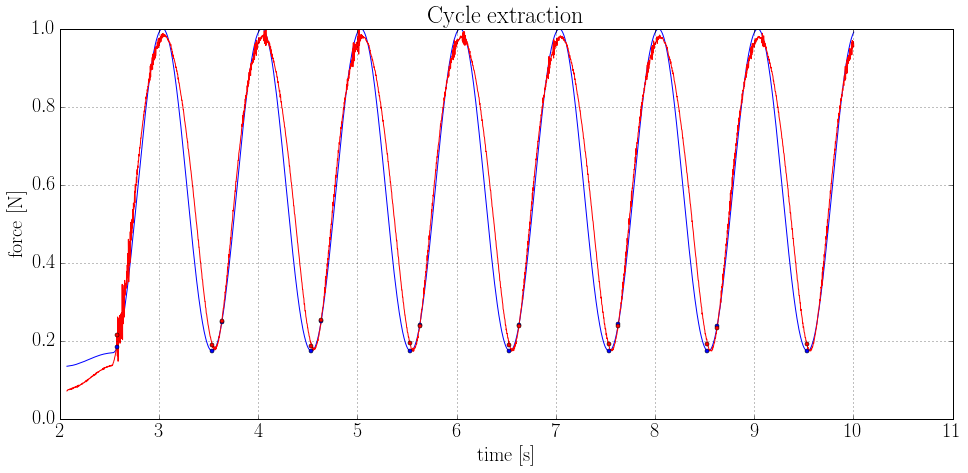

In [9]:
k = cut_cycles_at_value(force, preforce)
print 'Number of cycles recorded:', len(k)

plt.figure(figsize=(16, 7))
plt.plot(time, displ/displ.max(), 'b')
plt.plot(time, force/force.max(), 'r')
[plt.plot(time[ki], displ[ki]/displ.max(), 'bo', ms=4) for ki in k]
[plt.plot(time[ki], force[ki]/force.max(), 'ro', ms=4) for ki in k]
plt.title('Cycle extraction')
plt.xlabel('time [s]')
plt.ylabel('force [N]')

In [5]:
plt.plot(displ, force)

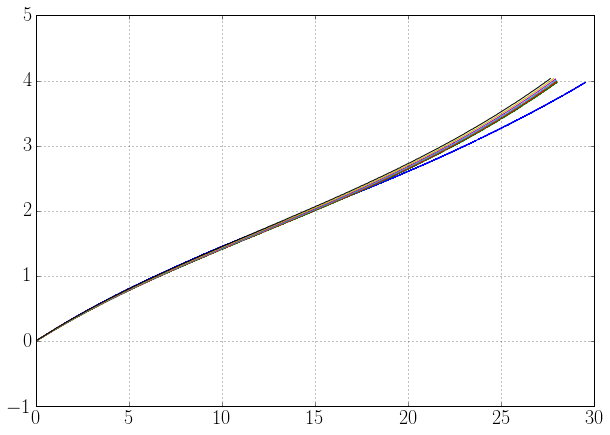

In [6]:
# collect branches and interpolate data
f_ld = []
u_ld = []
eps  = []
sig  = []

for ki in k:
    u = displ[ki[0]:ki[1]]
    f = force[ki[0]:ki[1]]
    
    idx_split = np.argmax(f)
    u_l, _    = branch_split(idx_split, u)
    f_l, _    = branch_split(idx_split, f)
    
    # shift
    u_l = u_l - u_l[0]
    f_l = f_l - f_l[0]
    
    # append lists
    u_ld.append(u_l)
    f_ld.append(f_l)

# scaling factor for global displacement to local strain (ensure that cycles correspond!)
sfac = epsx[-1]/u_ld[i_cycle-1][-1]
    
for u, f in zip(u_ld, f_ld):
    plt.plot(u, f)
    
    # scale global displacement to local strain
    epsi = u*sfac
    csarea_current = csarea/(epsi+1)
    sigi = f/(csarea_current)
    
    eps.append(epsi)
    sig.append(sigi)

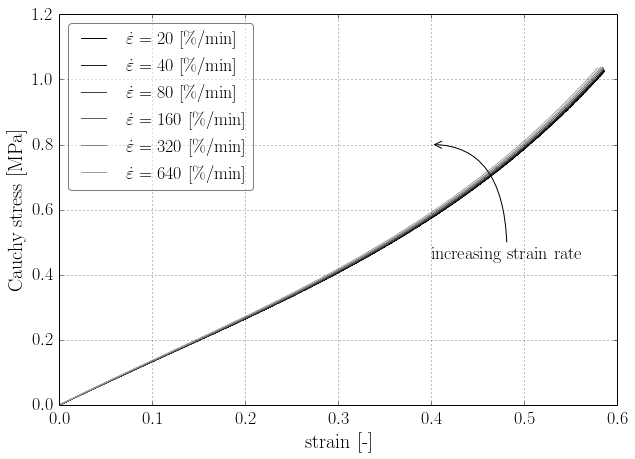

In [15]:
# plot cycles
n = 1
# plot the rest
# plt.plot(epsx, sig_cau, 'r', lw=2, label='ref. cycle\t\tat\t10 [\%/min]')

for i, (x, y) in enumerate(zip(eps[(i_cycle-1):], sig[(i_cycle-1):])):
    plt.plot(x, y, color=str(i/(len(eps[n:])+2)), lw=1, label=r'$\dot{\varepsilon} =$ ' +
                                                              str(10*2**(i+1)) + ' [\%/min]')

    
# annotation
plt.annotate("increasing strain rate", fontsize=18,
            xy=(0.4, 0.8), xycoords='data',
            xytext=(0.4, 0.45), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3"),
            )

# format axes
plt.ylim([0, 1.2])
plt.xlabel('strain [-]', fontsize=20)
plt.ylabel('Cauchy stress [MPa]', fontsize=20)
plt.legend(loc='best', fontsize=18, fancybox=True, framealpha=0.5)
plt.tick_params(labelsize=18, labelcolor='k')
plt.tick_params(axis='x', pad=6)
plt.tick_params(axis='y', pad=6)

plt.savefig('/home/rhopf/Dropbox/x_publications/journal/polymer_mechanics/pdms_properties-hopf/graphics/strain_rate_dependence.jpg')

# Save Data 

In [38]:
for i, (x, y) in enumerate(zip(eps[1:], sig[1:])):
    np.savetxt('/media/rhopf/phd_home/b_zurich_heart/a_experiments/final/V_UA_PDMS_cycle_' + str(i+1) + '.dat', np.array([x, y]).T)